In [1]:

from azureml.core import Dataset, Workspace, Datastore
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from azureml.core.experiment import Experiment
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

import logging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='new_az_project_demo', subscription_id='a7fc6b03-90cb-4440-a32b-407e97a3e341', resource_group='r02')

In [3]:
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

In [4]:
diabetes_df.dtypes


Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
desc = pd.DataFrame(diabetes_df.describe())
desc

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [6]:
# Count of missing values in each column
missing_values_count = diabetes_df.isnull().sum()
print(missing_values_count)

# Percentage of missing values in each column
missing_values_percent = diabetes_df.isnull().mean()
print(missing_values_percent)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64


In [7]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = diabetes_df['Outcome'].value_counts()/diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

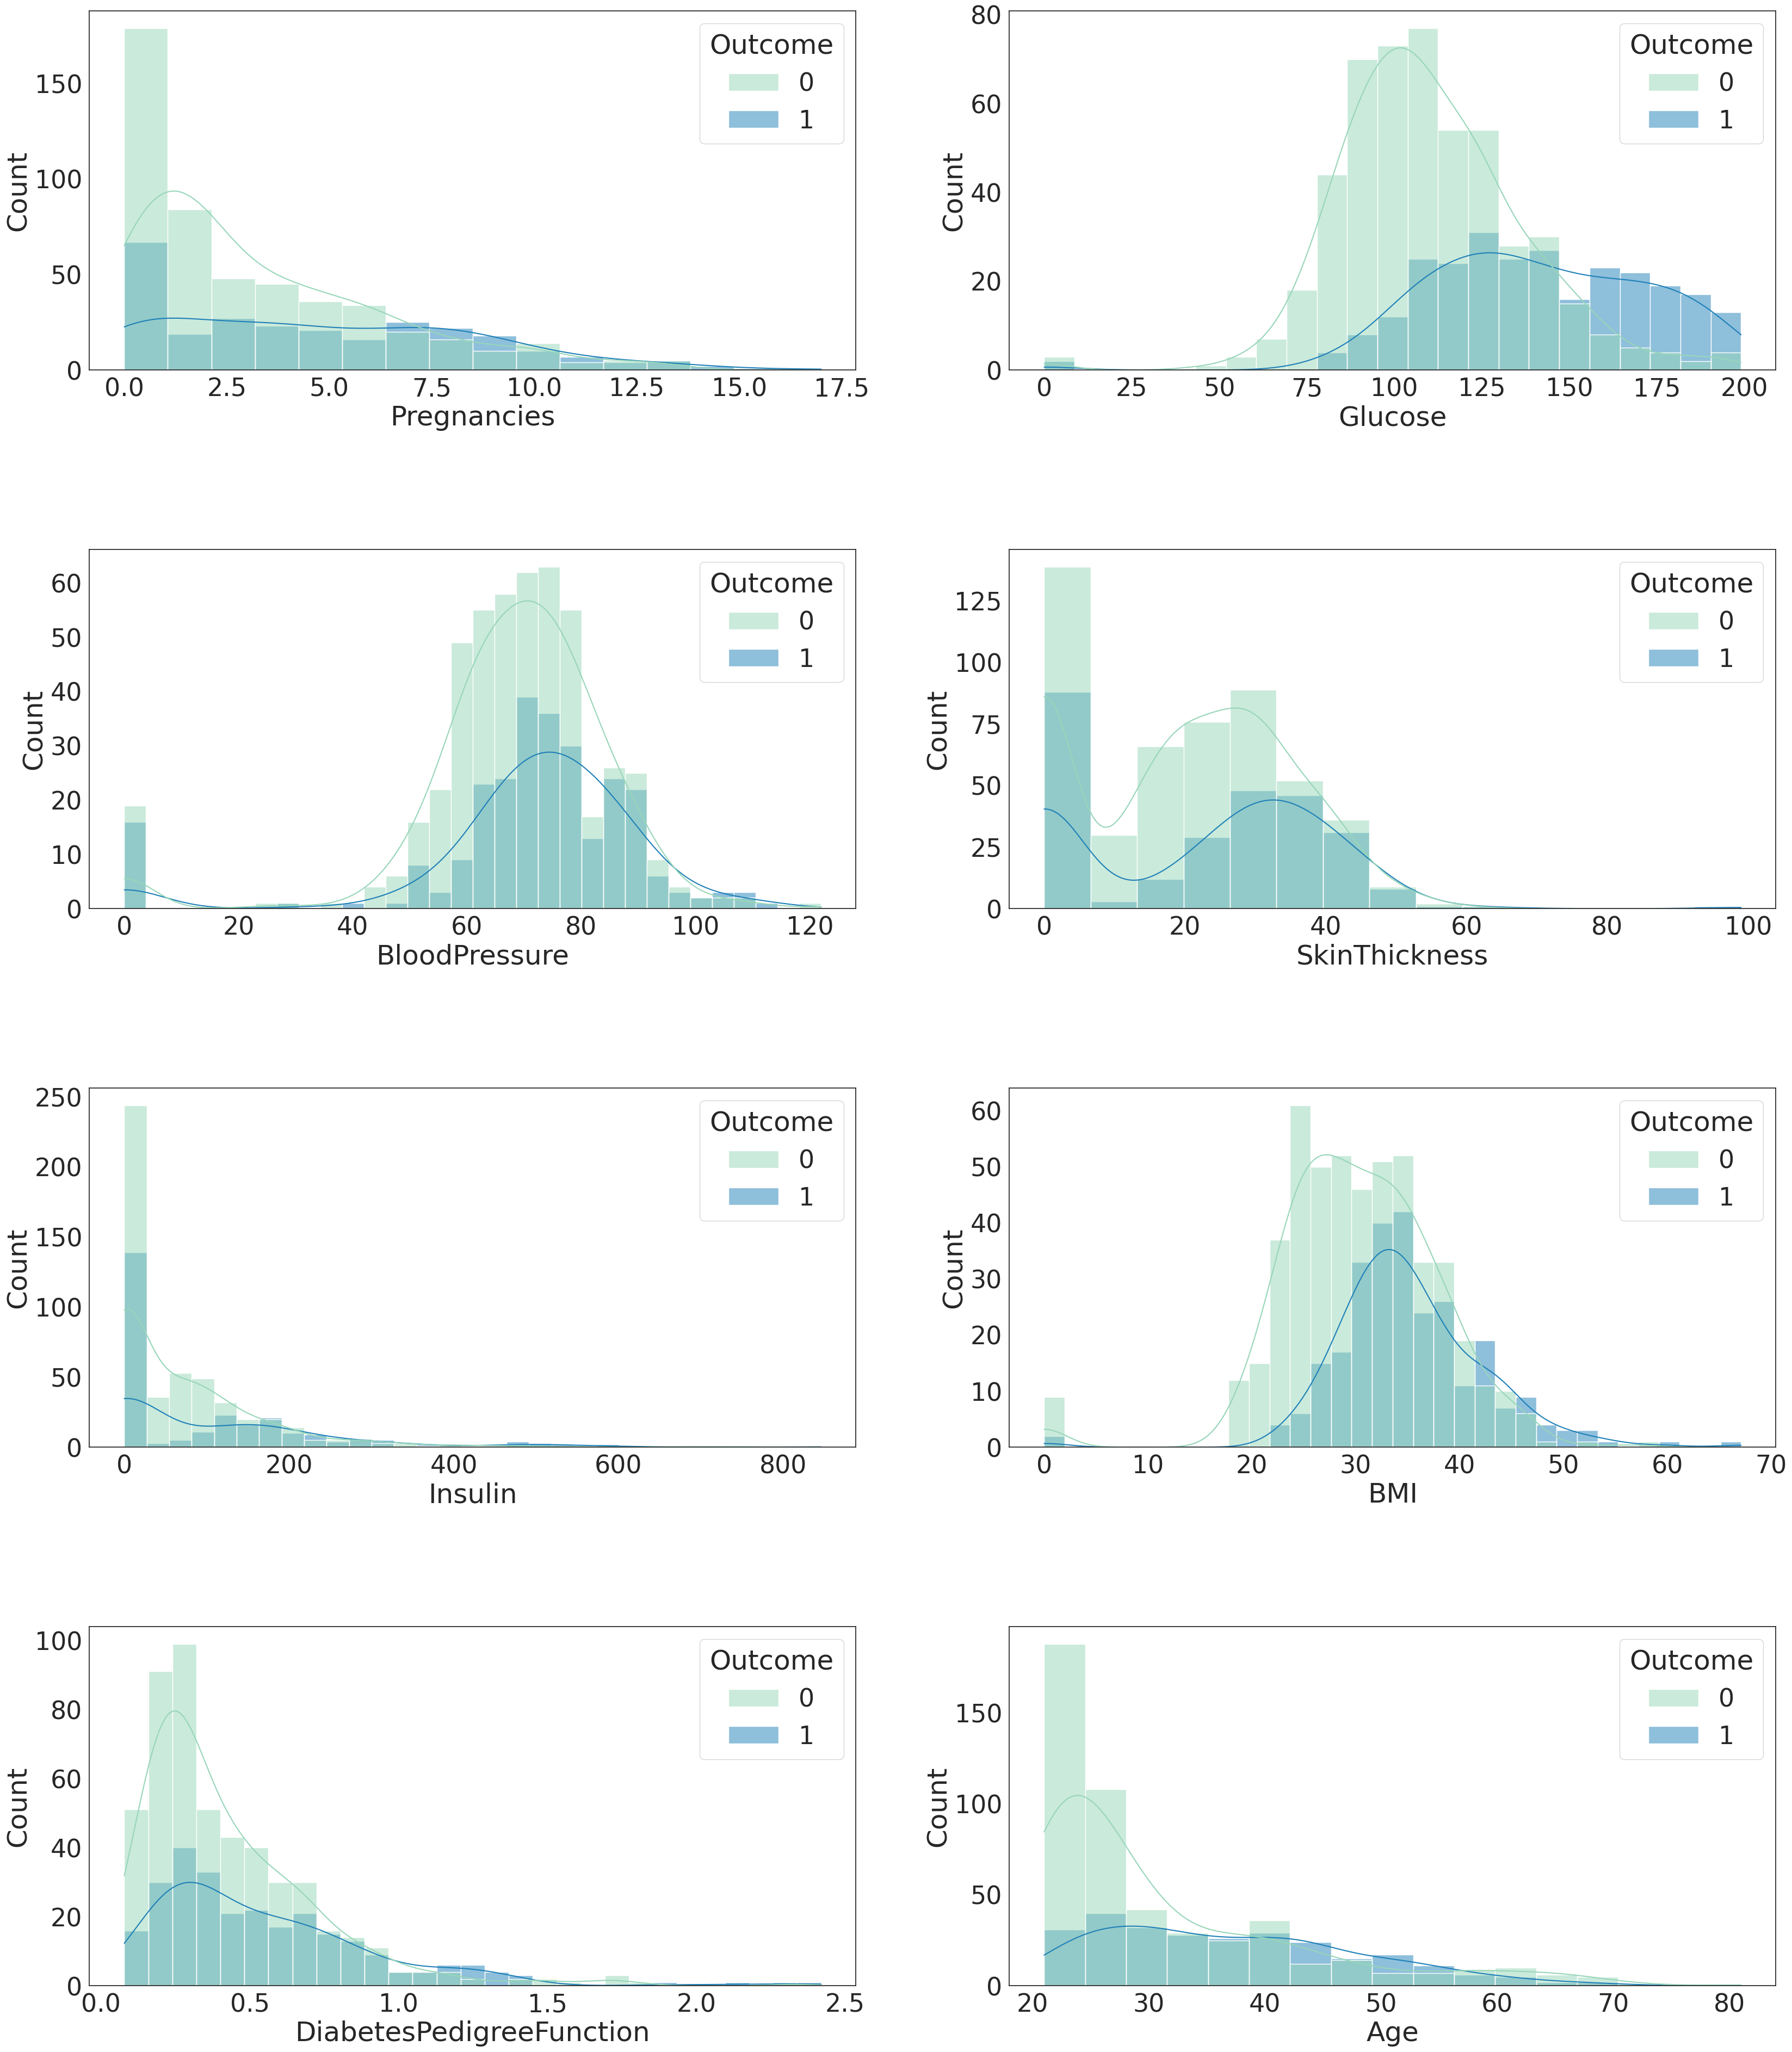

In [8]:
feature_names = [cname for cname in diabetes_df.loc[:,:'Age'].columns]
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

In [9]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


In [11]:
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)
diabetes_df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      4.400782  121.681605      72.254807      26.606479  118.660163   
std       2.984162   30.436016      12.115932       9.631241   93.080358   
min       1.000000   44.000000      24.000000       7.000000   14.000000   
25%       2.000000   99.750000      64.000000      20.536458   79.799479   
50%       3.845052  117.000000      72.000000      23.000000   79.799479   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450805                  0.471876   33.240885    0.348958  
std      6.875374                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [10]:
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

Text(0.5, 1.0, 'Correlation Plot')

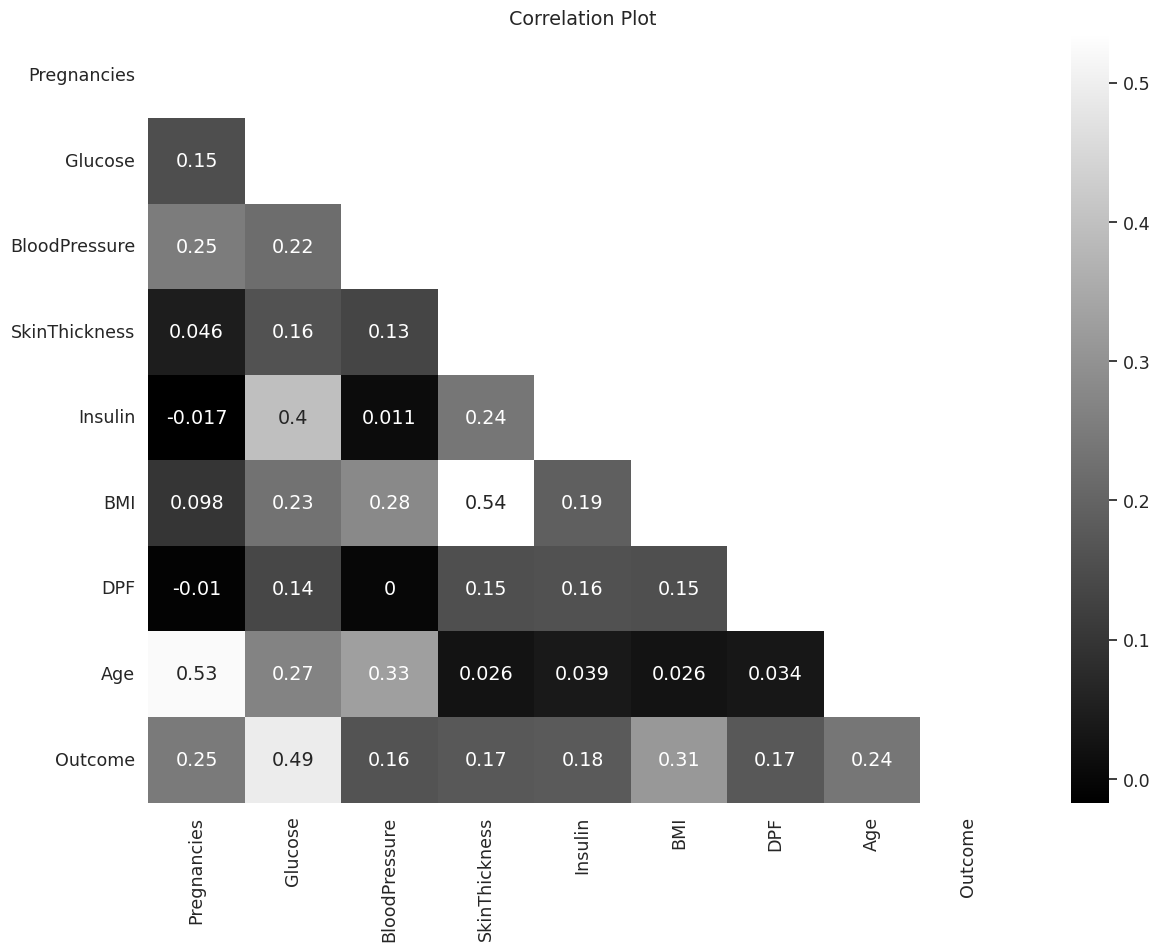

In [13]:
corr=diabetes_df.corr().round(3)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

<Figure size 1000x800 with 0 Axes>

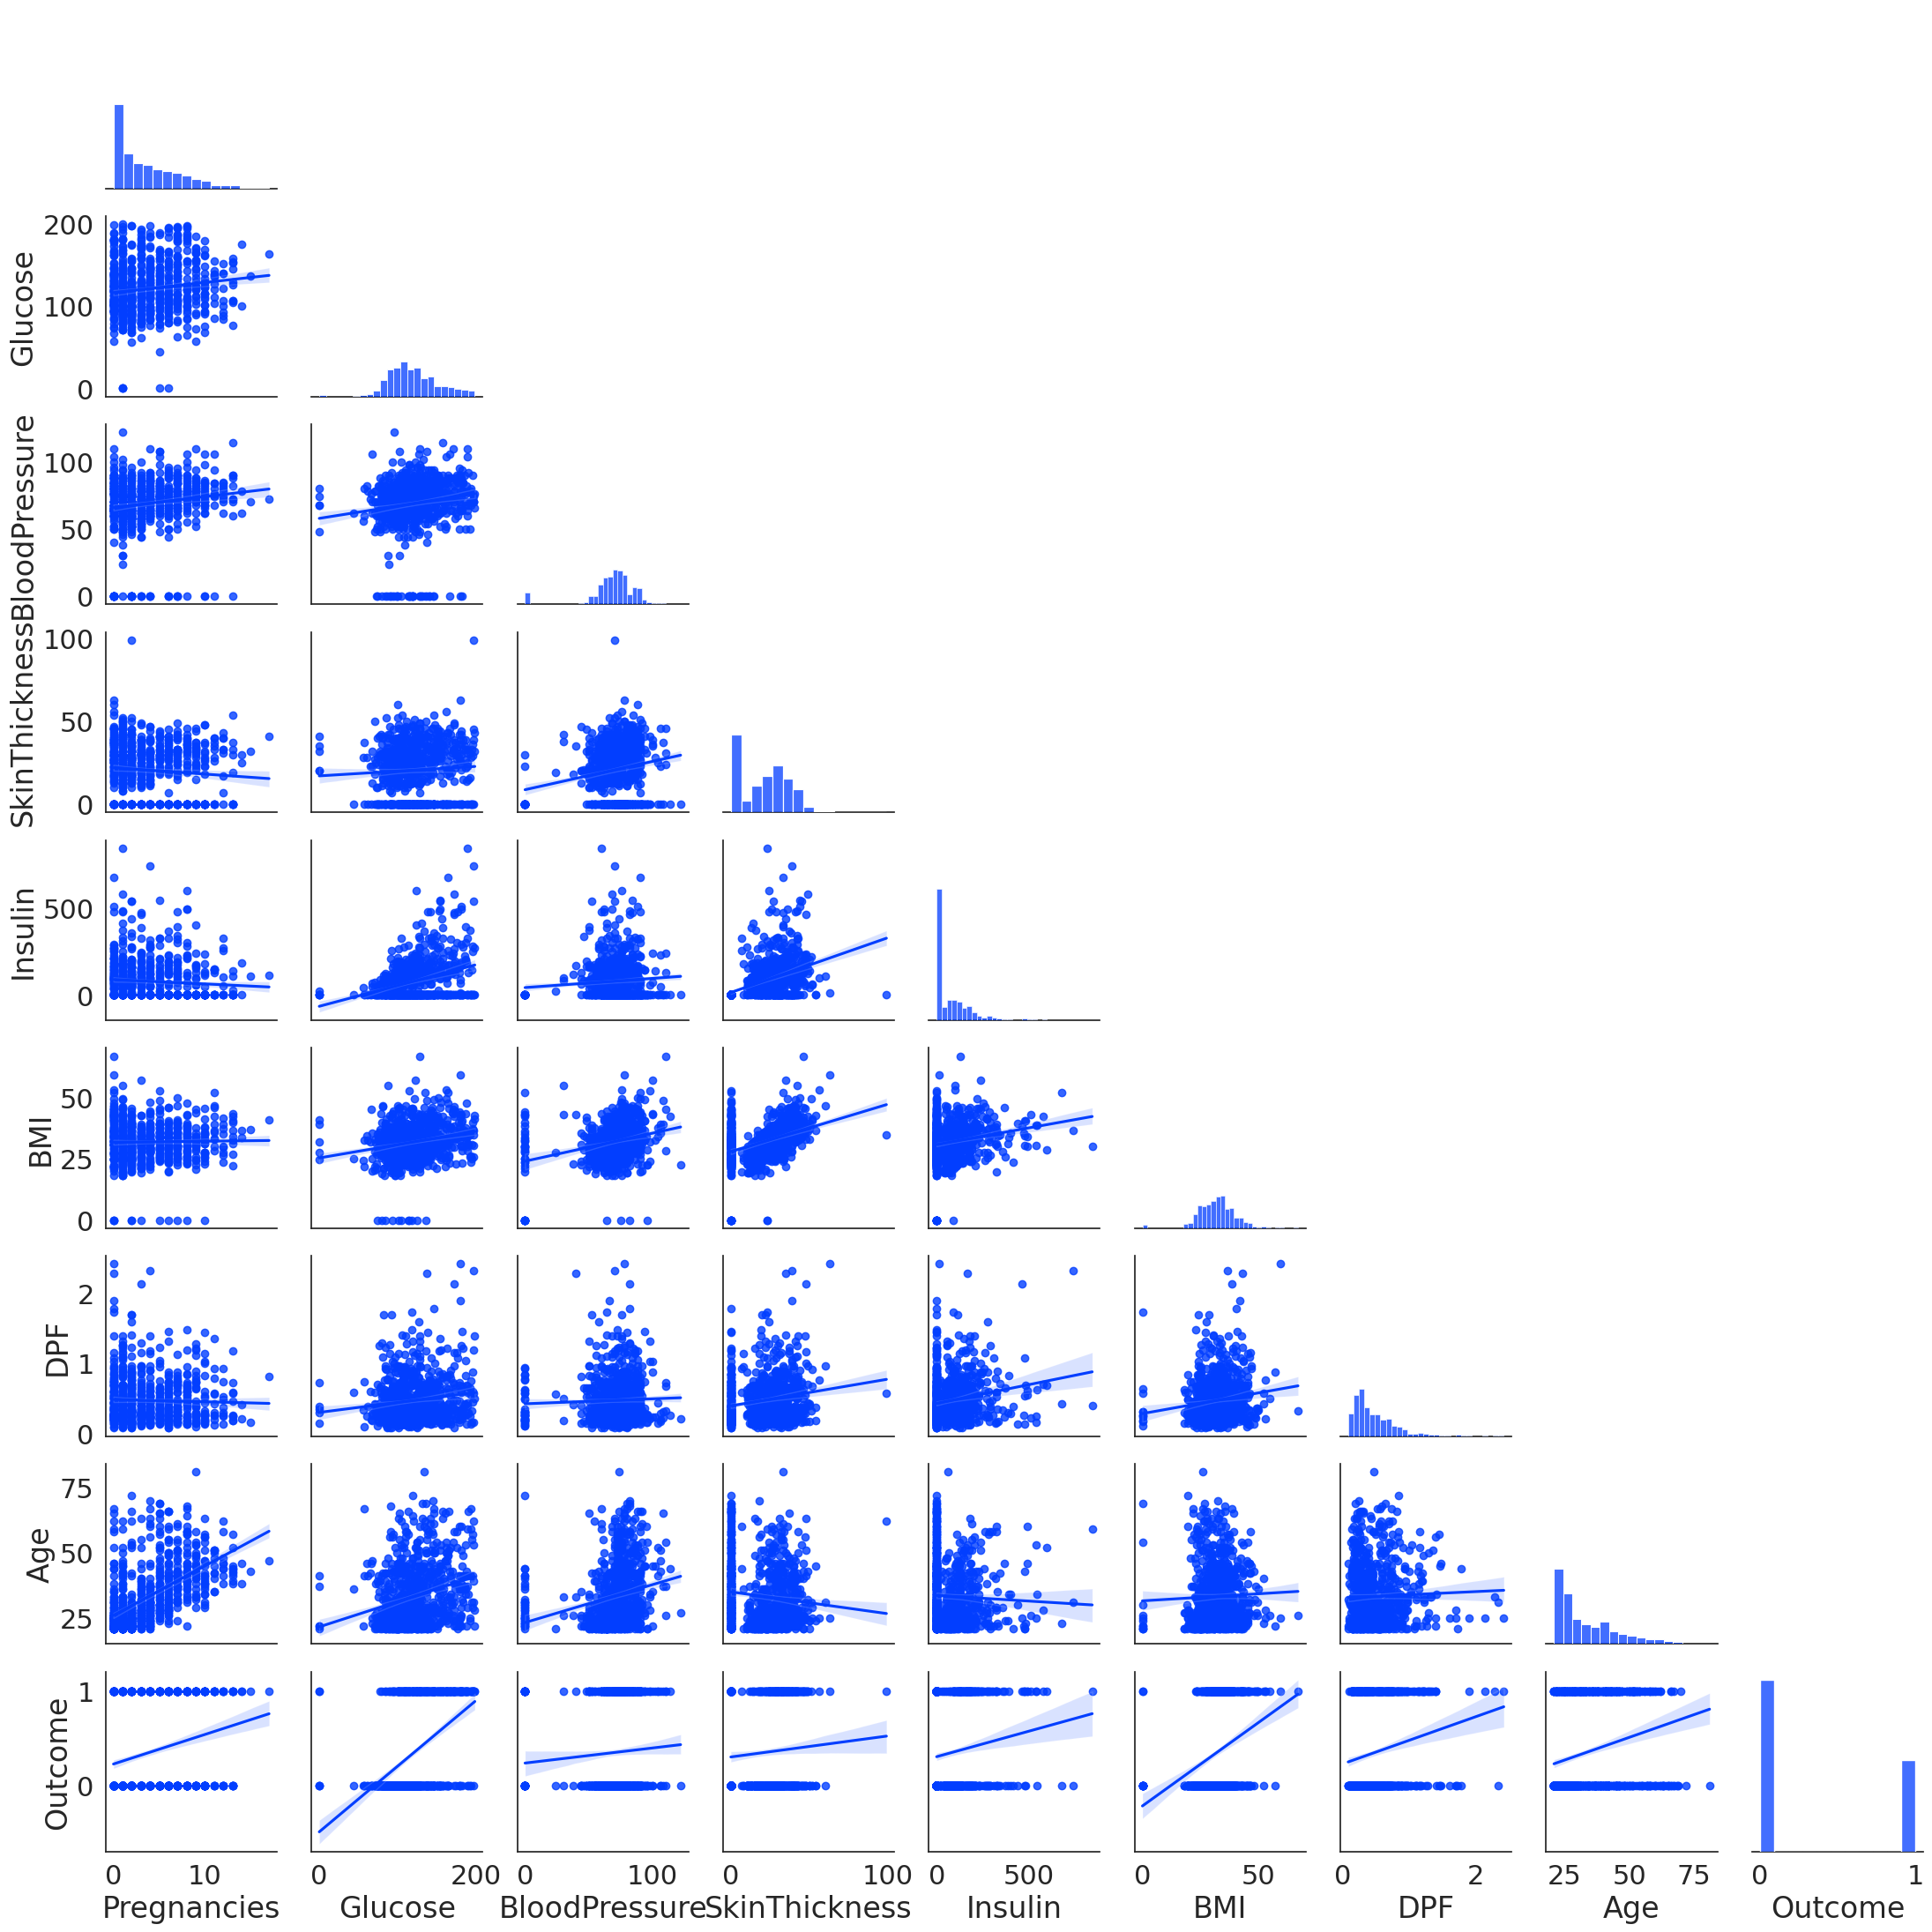

In [11]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(diabetes_df,kind = 'reg',corner = True,palette ='YlGnBu' )

# Modeling the data

In [12]:
X_train, X_test = train_test_split(diabetes_df, test_size=0.15, random_state=10000)

In [13]:
X_train_scaled_df = pd.DataFrame(X_train, columns=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DPF","Age","Outcome"])  # Add column names if needed
X_test_scaled_df = pd.DataFrame(X_test, columns=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DPF","Age","Outcome"])

In [14]:
print(len(X_train))
print(len(X_test))

652
116


In [15]:
scaled_dataset = Dataset.Tabular.register_pandas_dataframe(
    dataframe=X_train_scaled_df,
    target=(ws.get_default_datastore(), "scaled_dataset/train"),
    name="scaled_train_dataset",
    show_progress=True
)

scaled_test_dataset = Dataset.Tabular.register_pandas_dataframe(
    dataframe=X_test_scaled_df,
    target=(ws.get_default_datastore(), "scaled_dataset/test"),
    name="scaled_test_dataset",
    show_progress=True
)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to scaled_dataset/train/1e294998-a1d4-4dfe-8f1e-81154277285f/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to scaled_dataset/test/99fe0db8-8a84-41d3-9b53-4ec64d635b1a/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


# AutoML Configuration

In [16]:

automl_settings = {
    "iteration_timeout_minutes": 15,
    "experiment_timeout_hours": 1,
    "enable_early_stopping": True,
    "primary_metric": 'accuracy',  # Optimize for accuracy
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "n_cross_validations": 10,
    "max_concurrent_iterations": 5,
    "max_cores_per_iteration": -1,  # Use all available cores per iteration
    "enable_voting_ensemble": True,
    "enable_stack_ensemble": True,
}

In [17]:
train_dataset = Dataset.get_by_name(ws, name='scaled_train_dataset')
target_column_name = 'Outcome'

In [18]:
automl_config = AutoMLConfig(
    task='classification',
    debug_log="automated_ml_errors.log",
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target="Simple-Demo",
    **automl_settings
)

In [19]:
# Create an experiment
experiment = Experiment(ws, "automl-classification-stacking")

# Submit the AutoML run
automl_run = experiment.submit(automl_config, show_output=True)

Submitting remote run.
No run_configuration provided, running on Simple-Demo with default configuration
Running on remote compute: Simple-Demo


Experiment Id Type Status Details Page Docs Page automl-classification-stacking AutoML_f7662808-7430-4271-b6fb-57b38cc15093 automl NotStarted Link to Azure Machine Learning studio Link to Documentation


Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

**********************************************************************************

In [20]:

# Wait for the run to complete
automl_run.wait_for_completion(show_output=True)

Experiment Id Type Status Details Page Docs Page automl-classification-stacking AutoML_f7662808-7430-4271-b6fb-57b38cc15093 automl Completed Link to Azure Machine Learning studio Link to Documentation



********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feat

{'runId': 'AutoML_f7662808-7430-4271-b6fb-57b38cc15093',
 'target': 'Simple-Demo',
 'status': 'Completed',
 'startTimeUtc': '2024-06-08T09:40:14.680485Z',
 'endTimeUtc': '2024-06-08T10:05:27.101746Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'No scores improved over last 10 iterations, so experiment stopped early. This early stopping behavior can be disabled by setting enable_early_stopping = False in AutoMLConfig for notebook/python SDK runs.'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '10',
  'target': 'Simple-Demo',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-classification-stacking","subscription_id":"a7fc6b03-90cb-4440-a32b-407e97a3e341","resource_group":"r02","workspace_name":"new_az_project_demo","region":"eastus","compute_target":"Simple-Demo","spark_service"